## MCMC optimization

This example will optimize the generated mobility models we created in 01_parameter_generation

During parameter generation, we only fitted models against tracer diffusivity data since no thermodynamic information is necessary to compute these terms. However, these types of data does not account for chemical potential gradients. Diffusion data computed from a diffusion coupled (interdiffusivity) considered chemical potential gradients and must be assessed against. We can do that through MCMC optimization using Espei

In [ ]:
from espei.espei_script import run_espei

from kawin.mobility_fitting.utils import get_used_database_symbols

# register mobility error functions to espei
from kawin.mobility_fitting.error_functions import equilibrium_mobility_error, non_equilibrium_mobility_error

dbf_input = 'databases/CuNi_mob_gen.tdb'
dbf_output = 'databases/CuNi_mcmc.tdb'

# We set includeSubsystems to True to assess the endmember parameters as well. If we want to
# only free the mixing parameters, set this to False
cu_params = get_used_database_symbols(dbf_input, ['CU', 'NI'], 'CU', 'FCC_A1', includeSubsystems=True)
ni_params = get_used_database_symbols(dbf_input, ['CU', 'NI'], 'NI', 'FCC_A1', includeSubsystems=True)
params = sorted(cu_params + ni_params)

input_settings = {
    'system': {
        'phase_models': 'phase_models.json', 
        'datasets': 'datasets'
    },
    'mcmc': {
        'iterations': 1000,
        'scheduler': 'dask',
        'chains_per_parameter': 8,
        'cores': 8,
        'input_db': dbf_input,
        'symbols': params,
        'save_interval': 100,
    },
    'output': {
        'output_db': dbf_output,
        'tracefile': 'output/CuNi_trace.npy',
        'probfile': 'output/CuNi_prob.npy',
        'verbosity': 1
    }
}

In [ ]:
run_espei(input_settings)

We'll plot the probability to check if the MCMC converged, which appears to occur after around 400 iterations.

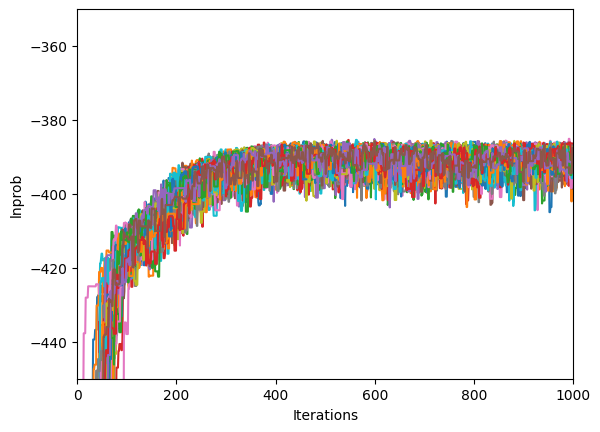

In [3]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

trace = np.load('output/CuNi_prob.npy')
ax.plot(trace.T)
ax.set_xlabel('Iterations')
ax.set_xlim([0, 1000])
ax.set_ylabel('lnprob')
ax.set_ylim([-450, -350])
plt.show()

### Comparing generated models to interdiffusivity

Before we optimize the model, let's check how well the initial mobility models compare against the interdiffusivity data.

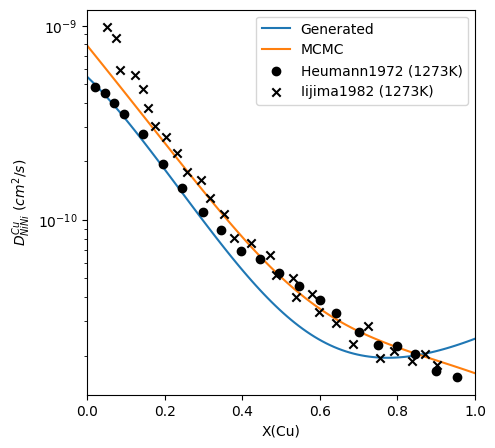

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tinydb import where

from espei.datasets import load_datasets, recursive_glob

from kawin.thermo import GeneralThermodynamics

# Helper function to plot interdiffusivity
def plot_interdiffusivity_datasets(ax, components, reference, scale=1, *args, **kwargs):
    datasets = load_datasets(sorted(recursive_glob('datasets', '*.json')))
    query = (
        (where('components').test(lambda x: set(x).issubset(components + ['VA']))) & 
        (where('output').test(lambda x: x == 'INTER_DIFF')) &
        (where('reference').test(lambda x: x == reference))
    )
    data = datasets.search(query)

    for d in data:
        x_cu = np.array(d['conditions']['X_CU'])
        T = d['conditions']['T']
        values = np.array(d['values']).flatten()
        ref = d['reference']
        
        # Plot Ni composition
        x_ni = 1-x_cu
        ax.scatter(x_ni, scale*np.array(values), label=f'{ref} ({int(T)}K)', *args, **kwargs)

components = ['CU', 'NI']
phase = 'FCC_A1'

T = 1273
x = np.linspace(1e-3, 1-1e-3, 100)
therm_gen = GeneralThermodynamics('databases/CuNi_mob_gen.tdb', components, [phase])
therm_mcmc = GeneralThermodynamics('databases/CuNi_mcmc.tdb', components, [phase])

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x, therm_gen.getInterdiffusivity(x, T)*1e4, label='Generated', zorder=0)
ax.plot(x, therm_mcmc.getInterdiffusivity(x, T)*1e4, label='MCMC', zorder=0)
plot_interdiffusivity_datasets(ax, components, 'Heumann1972', scale=1e4, marker='o', color='k')
plot_interdiffusivity_datasets(ax, components, 'Iijima1982', scale=1e4, marker='x', color='k')

ax.set_xlim([0,1])
ax.set_xlabel('X(Cu)')
ax.set_ylabel('$D^{Cu}_{NiNi}$ ($cm^2/s$)')
ax.set_yscale('log')
ax.legend()
plt.show()

We could plot the prefactor and activation energy of the tracer diffusivity with the optimized database to show that agreement is retained with the original tracer diffusivity data.

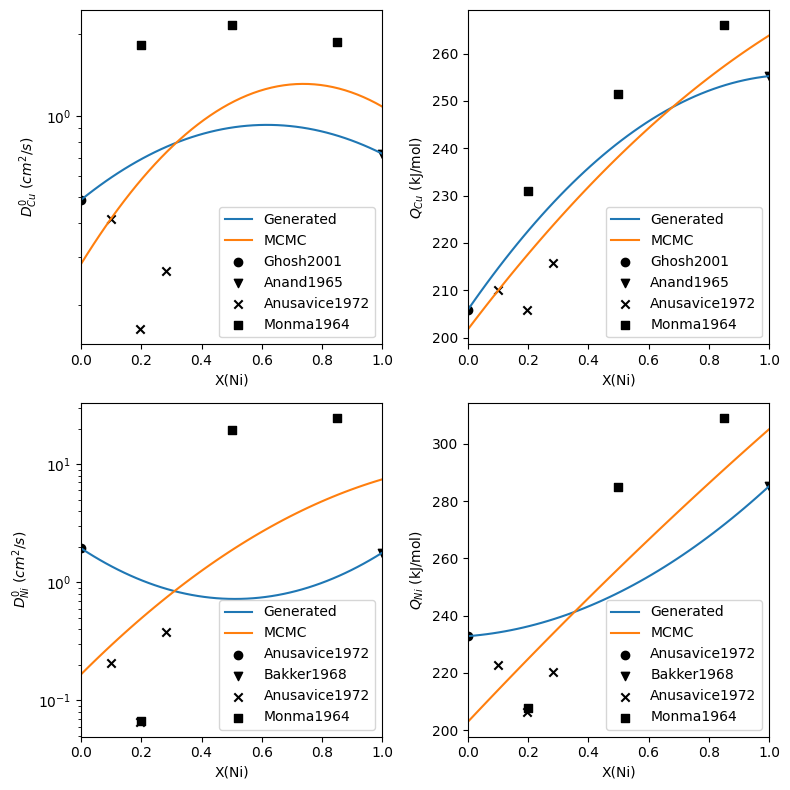

In [5]:
import itertools

import numpy as np
import matplotlib.pyplot as plt

from kawin.thermo import GeneralThermodynamics
from kawin.mobility_fitting.manual_fitting import grab_tracer_datasets
from kawin.thermo.Mobility import activation_energy_from_composition_set_phase_record, prefactor_from_composition_set_phase_record

# Helper function to plot Q or D0 for a given species
def plot_datasets(ax, output, diffusing_species, scale=1):
    symbols = ['o', 'v', 'x', 's', '+', '1', 'd', '_', '^', '<']
    symbol_cycle = itertools.cycle(symbols)

    datasets = grab_tracer_datasets('datasets', output, 'FCC_A1', ['CU', 'NI', 'VA'], diffusing_species)
    for d in datasets:
        sub_config = d['solver']['sublattice_configurations']
        sub_occ = d['solver']['sublattice_occupancies']
        x_ni = []
        for sc, so in zip(sub_config, sub_occ):
            if isinstance(sc[0], str):
                if sc[0] == 'CU':
                    x_ni.append(1-so[0])
                elif sc[0] == 'NI':
                    x_ni.append(so[0])
            else:
                x_ni.append(so[0][sc[0].index('NI')])
        values = np.array(d['values']).flatten()
        ref = d['reference']
        ax.scatter(x_ni, scale*values, label=ref, marker=next(symbol_cycle), color='k')

components = ['CU', 'NI']
phase = 'FCC_A1'

# Compute activation energy and pre-factor for Nb and Ti
N = 50
xs = np.linspace(1e-3, 1-1e-3, N)
T = 1273
qs_gen = np.zeros((N, 2))
qs_mcmc = np.zeros((N, 2))
lnd0s_gen = np.zeros((N, 2))
lnd0s_mcmc = np.zeros((N, 2))
for i, x in enumerate(xs):
    results, comp_sets = therm_gen.getLocalEq(x, T, precPhase=[phase])
    qs_gen[i] = activation_energy_from_composition_set_phase_record(comp_sets[0], therm_gen.mob_phase_records, phase, components)
    qs_mcmc[i] = activation_energy_from_composition_set_phase_record(comp_sets[0], therm_mcmc.mob_phase_records, phase, components)

    lnd0s_gen[i] = prefactor_from_composition_set_phase_record(comp_sets[0], therm_gen.mob_phase_records, phase, components)
    lnd0s_mcmc[i] = prefactor_from_composition_set_phase_record(comp_sets[0], therm_mcmc.mob_phase_records, phase, components)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Plot D0 for Nb mobility
axes[0,0].plot(xs, 1e4*np.exp(lnd0s_gen[:,0]), label='Generated')
axes[0,0].plot(xs, 1e4*np.exp(lnd0s_mcmc[:,0]), label='MCMC')
plot_datasets(axes[0,0], 'D0', 'CU', scale=1e4)
axes[0,0].set_yscale('log')
axes[0,0].set_ylabel('$D^0_{Cu}$ ($cm^2/s$)')

# Plot Q for Nb mobility
axes[0,1].plot(xs, 1e-3*qs_gen[:,0], label='Generated')
axes[0,1].plot(xs, 1e-3*qs_mcmc[:,0], label='MCMC')
plot_datasets(axes[0,1], 'Q', 'CU', scale=1e-3)
axes[0,1].set_ylabel('$Q_{Cu}$ (kJ/mol)')

# Plot D0 for Ti mobility
axes[1,0].plot(xs, 1e4*np.exp(lnd0s_gen[:,1]), label='Generated')
axes[1,0].plot(xs, 1e4*np.exp(lnd0s_mcmc[:,1]), label='MCMC')
plot_datasets(axes[1,0], 'D0', 'NI', scale=1e4)
axes[1,0].set_yscale('log')
axes[1,0].set_ylabel('$D^0_{Ni}$ ($cm^2/s$)')

# Plot Q for Ti mobility
axes[1,1].plot(xs, 1e-3*qs_gen[:,1], label='Generated')
axes[1,1].plot(xs, 1e-3*qs_mcmc[:,1], label='MCMC')
plot_datasets(axes[1,1], 'Q', 'NI', scale=1e-3)
axes[1,1].set_ylabel('$Q_{Ni}$ (kJ/mol)')

for ax in axes.reshape(-1):
    ax.set_xlim([0,1])
    ax.set_xlabel('X(Ni)')
    ax.legend()

fig.tight_layout()
plt.show()

### Uncertainty quantification

Since we have the trace files, we can compute the interdiffusivity for the sampled parameters to obtain 95% confidence intervals.

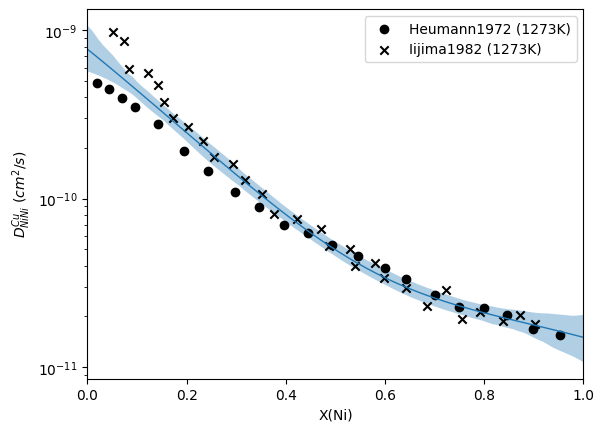

In [6]:
fig, ax = plt.subplots()

T = 1273
x = np.linspace(1e-3, 1-1e-3, 100)

# Set our fitted parameters to be freed symbols
therm = GeneralThermodynamics('databases/CuNi_mcmc.tdb', ['CU', 'NI', 'VA'], ['FCC_A1'], parameters = params)

# Plot datasets
plot_interdiffusivity_datasets(ax, components, 'Heumann1972', scale=1e4, marker='o', color='k')
plot_interdiffusivity_datasets(ax, components, 'Iijima1982', scale=1e4, marker='x', color='k')

# Remove first 75 parameters from trace and reshape to (N, params)
trace = np.load('output/CuNi_trace.npy')
trace = trace[:,500:]
trace = trace.reshape(-1, trace.shape[-1])

# Sample 100 iterations from the trace and compute interdiffusivity
diffs = []
N = 200
for n in range(N):
    index = int(n*trace.shape[0] / N)
    param_map = {p: trace[index, i] for i, p in enumerate(params)}
    therm.updateParameters(param_map)
    diffs.append(therm.getInterdiffusivity(x, T))

# Plot the average diffusivity along with 2 sigma intervals
diffs = np.array(diffs)
avg = np.exp(np.average(np.log(diffs), axis=0))
d_low = np.percentile(diffs, 97.5, axis=0)
d_high = np.percentile(diffs, 2.5, axis=0)
ax.plot(x, 1e4*avg, color='C0', linewidth=1, zorder=1)
ax.fill_between(x, 1e4*d_low, 1e4*d_high, alpha=0.35, zorder=0)

ax.set_xlim([0, 1])
ax.set_xlabel('X(Ni)')
ax.set_ylabel('$D^{Cu}_{NiNi}$ ($cm^2/s$)')
ax.set_yscale('log')
ax.legend()
plt.show()

Finally, now that we have an assessed database, we can simulate a diffusion couple.

Iteration	Sim Time (h)	Run time (s)
0		0.000e+00		0.0
100		2.092e+01		2.9
200		4.183e+01		5.1
300		6.275e+01		6.7
400		8.366e+01		8.0
500		1.046e+02		9.0
600		1.255e+02		10.0
700		1.466e+02		10.9
717		1.500e+02		11.0


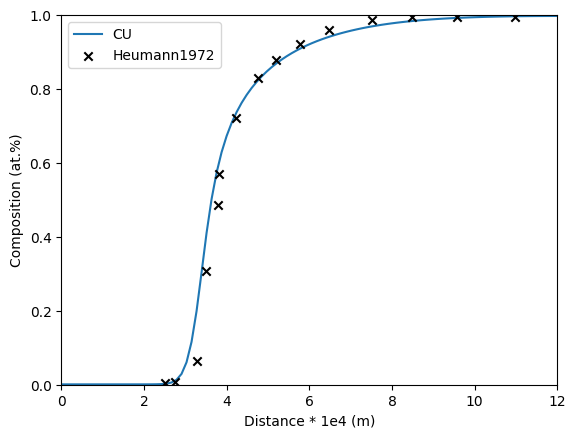

In [12]:
from kawin.diffusion import SinglePhaseModel, CompositionProfile, TemperatureParameters

components = ['NI', 'CU']
phases = ['FCC_A1']
therm = GeneralThermodynamics('databases/CuNi_mcmc.tdb', components, phases)

temperature = TemperatureParameters(1273)
profile = CompositionProfile()
profile.addStepCompositionStep('CU', 1e-3, 1-1e-3, 4e-4)

model = SinglePhaseModel([0, 12e-4], 100, components, phases, thermodynamics=therm,
                         compositionProfile=profile, temperatureParameters=temperature)

model.solve(150*3600, verbose=True, vIt=100)

fig, ax = plt.subplots()
model.plot(ax, plotReference=False, zScale=1e-4)

heumann_data = np.array([
    [2.508e-4, 0.005],
    [2.749e-4, 0.008],
    [3.275e-4, 0.063],
    [3.494e-4, 0.307],
    [3.801e-4, 0.485],
    [3.823e-4, 0.571],
    [4.239e-4, 0.723],
    [4.765e-4, 0.830],
    [5.203e-4, 0.879],
    [5.773e-4, 0.923],
    [6.474e-4, 0.959],
    [7.525e-4, 0.988],
    [8.478e-4, 0.994],
    [9.584e-4, 0.995],
    [10.986e-4, 0.995],
])
ax.scatter(heumann_data[:,0]/1e-4, heumann_data[:,1], marker='x', color='k', label='Heumann1972', zorder=2)
ax.set_xlabel('Distance * 1e4 (m)')
ax.set_ylim([0,1])
ax.legend()
plt.show()

### References for dataset

1. G. Ghosh, Acta Mater. 49 (2001) 2609.
2. M.S. Anand, S.P. Murarka, R.P. Agarwala, J. Appl. Phys. 36 (1965) 3860.
3. H. Bakker, Phys. Stat. Sol. 28 (1958) 569.
4. K.J. Anusavice, J.J. Pinajian, K. Oikawa, R.T. DeHoff, Trans. Metal. Soc. AIME 242 (1968) 2027.
5. K. Monma, H. Suto, H. Oikawa, J. Japan Inst. Met. 28 (1964) 192.
6. V.T. Heumann, K.J. Grundhoff, Z. Metallk. 63 (1972) 173.
7. Y. Iijima, K. Hirano, M. Kikuchi, Trans. Japan Inst. Met. 23 (1982) 19.